In [111]:
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import re
import plotly.express as px

import sys
sys.path.append('src/')
from pint import UnitRegistry

from webscraper import parse_url_info, drop_duplicate_product_urls

In [77]:

def parse_volume_string(input_string):
    # thank you chatgpt <3
    pattern = r'(\d+(\.\d+)?)\s*(\w+)\s+(\d+(\.\d+)?)\s*(\w+)\s*(.*)'
    matches = re.search(pattern, input_string)
    if matches:
        amount1 = matches.group(1)
        unit1 = matches.group(3)
        amount2 = matches.group(4)
        unit2 = matches.group(6)
        trailing_text = matches.group(7).strip()
        return amount1, unit1, amount2, unit2, trailing_text
    return None

def parse_single_volume(input_string):
    pattern = r'\s*(\d+(\.\d*)?|\.\d+)\s*(\w+)\s*'
    matches = re.match(pattern, input_string)
    if matches:
        amount = matches.group(1)
        unit = matches.group(3)
        return amount, unit
    return None

def shorthand_amt_conversion(value):
    if value:
        return value.replace(".","").replace("K","00").replace("M","000000")
    return None



In [78]:
product_files = glob.glob("data/products/*")
products = []
for product_file in product_files:
    with open(product_file) as file:
        products.append(pd.json_normalize(json.loads(file.read())))
        
df_products = pd.concat(products, axis=0)
df_products = df_products[df_products['product_name'].notnull()]
df_products = df_products.reset_index(drop=True).reset_index().rename(columns={'index':'internal_product_id'})

In [79]:
# product ratings
df_products['rating'] = df_products['rating'].str.replace("width:","")
df_products['rating'] = df_products['rating'].str.replace("%","")
df_products['rating'] = df_products['rating'].astype(float)
df_products['rating'] = df_products['rating']/100 * 5

df_products['n_loves'] = df_products['n_loves'].apply(shorthand_amt_conversion)
df_products['n_loves'] = df_products['n_loves'].astype(float)

df_products['product_reviews'] = df_products['product_reviews'].apply(shorthand_amt_conversion)
df_products['product_reviews'] = df_products['product_reviews'].astype(float)


product_options = []
for product in df_products.iterrows():
    url = product[1]['url']
    df_options = pd.json_normalize(product[1]['options'])
    df_options['url'] = url
    product_options.append(df_options)
    
df_products = df_products.merge(pd.concat(product_options), how='left', on='url')

df_products['name'] =  df_products['name'].str.lower()
df_products['size'] =  df_products['size'].str.lower()

df_products['price'] = df_products['price'].str.replace("$","")
df_products['price'] = df_products['price'].astype(float)

df_products['out_of_stock'] = df_products['name'].str.contains('out of stock')
df_products['limited_edition'] = df_products['name'].str.contains('limited edition')
df_products['new_product'] = df_products['name'].str.contains('new')
df_products['few_left'] = df_products['name'].str.contains('only a few left')
df_products['sale'] = df_products['name'].str.contains('sale')
df_products['refill'] = df_products['name'].str.contains('refill')

df_products.loc[df_products['size'].isna(), 'size'] = df_products['name']
df_products.loc[df_products['size']==df_products['name'],'name'] = None

misc_text = {
    "out of stock":"",
    "limited edition":"",
    "new":"",
    "only a few left":"",
    "sale":"",
    "size":"",
    "refill":"",
    "color":"",
    ":":"",
    "-":"",
    "mini":"",
    "fl oz":"floz",
    "fl. oz":"floz",
    "oz.":"oz ",
    "/":" ",
    r'\s+': ' '
}

def series_replace(df, ids):
    df['size'] = df['size'].replace(ids, regex=True)
    return df

df_products =  series_replace(df_products,misc_text)

df_products['sku'] = df_products['sku'].str.replace("Item ","")

df_products['size'] = df_products['size'].fillna("")
df_products['size'] = df_products['size'].str.strip()
df_products.loc[df_products['size'].str[0]=='.', 'size'] = "0"+df_products['size']

df_products.loc[df_products['size'].str.contains('x'),'product_multiplier'] = df_products['size'].apply(size_w_multiplier)
df_products.loc[df_products['product_multiplier'].notnull(), 'multiplier'] = df_products['product_multiplier'].str[0]
df_products.loc[df_products['product_multiplier'].notnull(), 'size'] = df_products['product_multiplier'].str[1]

df_products['amount_a'], df_products['unit_a'], df_products['amount_b'], df_products['unit_b'], df_products['misc_info'] = df_products['size'].apply(parse_volume_string).str
df_products[['amount_a','amount_b']] = df_products[['amount_a','amount_b']].astype(float)

df_products['amount_single'], df_products['unit_single'] = df_products[df_products['amount_a'].isna()]['size'].apply(parse_single_volume).str

df_products['url_path'], df_products['url_sku'], df_products['url_params'] =  df_products['url'].apply(parse_url_info).str
df_products = df_products.drop_duplicates(subset=['brand_name','product_name','url_path', 'sku','price'], keep='last')
df_products['amount_single']= df_products['amount_single'].astype(float)

df_products.loc[df_products['amount_a'].isna(), 'amount_a'] = df_products['amount_single']
df_products.loc[df_products['amount_a'].isna(), 'unit_a'] = df_products['unit_single']

df_products = df_products.drop(['amount_single','unit_single'],axis=1)

df_products['categories'] = df_products['categories'].fillna('   ')
df_products['lvl_0_cat'], df_products['lvl_1_cat'], df_products['lvl_2_cat'] = df_products['categories'].str


df_products['swatch_details'] = df_products['swatch_group'].str.split(" - ").str[0]
df_products['swatch_group'] = df_products['swatch_group'].str.split(" - ").str[-1]

/var/folders/3_/49qq58ns2r11fnng7d9pbd0w0000gn/T/ipykernel_9422/784564696.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_products['price'] = df_products['price'].str.replace("$","")
/var/folders/3_/49qq58ns2r11fnng7d9pbd0w0000gn/T/ipykernel_9422/784564696.py:74: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_products['amount_a'], df_products['unit_a'], df_products['amount_b'], df_products['unit_b'], df_products['misc_info'] = df_products['size'].apply(parse_volume_string).str
/var/folders/3_/49qq58ns2r11fnng7d9pbd0w0000gn/T/ipykernel_9422/784564696.py:77: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_products['amount_single'], df_products['unit_single'] = df_products[df_products['amount_a'].isna()]['size'].apply(parse_single_vol

In [81]:
allowed_units = ['ml','fl','floz','g','oz','kg','mg']

print(df_products.shape)

df_products = df_products[(df_products['unit_a'].isin(allowed_units)) & (df_products['unit_b'].isin(allowed_units))]
df_products.loc[(df_products['unit_a']=='oz') & (df_products['unit_b']=='ml'),'unit_a']='floz'
df_products.loc[(df_products['unit_a']=='fl'),'unit_a']='floz'


(17873, 34)


In [133]:
df_products['swatch_group'].value_counts()

Standard size    15180
Mini size         2258
Value size         225
Refill size        210
Name: swatch_group, dtype: int64

In [134]:
df_products.groupby(['unit_a','unit_b'])['sku'].nunique()

unit_a  unit_b
floz    g             1
        ml        10832
g       oz            9
ml      floz          9
        g             3
        oz            8
oz      g          5825
        kg            1
        mg            1
        oz            1
Name: sku, dtype: int64

In [121]:
def conv_solid(row):

    return ureg(str(row['amount_a'])+" "+row['unit_a']).to(row['unit_b'])

solid_products = df_products[(df_products['unit_a']=='oz') & (df_products['unit_b']=='g')]
solid_products['a_conv'] = solid_products.apply(conv_solid, axis=1)
solid_products['a_conv_magnitude'] = solid_products['a_conv'].apply(lambda x : x.magnitude)

/Users/hannahleblanc/opt/anaconda3/envs/pc-env/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/var/folders/3_/49qq58ns2r11fnng7d9pbd0w0000gn/T/ipykernel_9422/4094345848.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solid_products['a_conv'] = solid_products.apply(conv_solid, axis=1)
/var/folders/3_/49qq58ns2r11fnng7d9pbd0w0000gn/T/ipykernel_9422/4094345848.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [122]:
solid_products = solid_products.groupby(['brand_name','product_name','swatch_group'], as_index=False).agg({
    'sku':['unique','count'],
    'rating':'first',
    'product_reviews':'first',
    'price':['first','unique','nunique'],
    'size':'first',
    'name':'nunique',
    'amount_a':'first',
    'unit_a':'first',
    'amount_b':'first',
    'unit_b':'first',
    'lvl_0_cat':'first',
    'lvl_1_cat':'first',
    'lvl_2_cat':'first'
})
solid_products.columns = ['_'.join(x) for x in solid_products.columns]
# solid_products[solid_products['a_conv_magnitude']!=solid_products['amount_b']].head()

In [ ]:

df_products_tree = df_products.groupby(['lvl_0_cat', 'lvl_1_cat', 'lvl_2_cat','brand_name'], as_index=False)['url'].count()
fig = px.treemap(df_products_tree, path=[px.Constant("all"), 'lvl_0_cat', 'lvl_1_cat', 'lvl_2_cat','brand_name'], values='url')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [ ]:
df_products[(df_products['lvl_2_cat']=='Concealer') & (df_products['brand_name']=='Glossier')]

In [ ]:
# df_products['unit_a'].value_counts()
mascara_df = df_products[(df_products['lvl_2_cat']=='Mascara') & (df_products['unit_a']=='oz')].groupby(['brand_name','product_name','swatch_group'], as_index=False).agg({
    'price':'first',
    'amount_a':'first',
    'unit_a':'first'
})

In [120]:
solid_products.head()

,brand_name_,swatch_group_,sku_unique,sku_count,product_name_first,rating_first,product_reviews_first,price_first,price_unique,price_nunique,size_first,name_nunique,amount_a_first,unit_a_first,amount_b_first,unit_b_first,lvl_0_cat_first,lvl_1_cat_first,lvl_2_cat_first
0,ALTERNA Haircare,Standard size,[2143436],1,CAVIAR Anti-Aging Restructuring Bond Repair Le...,4.5000,4.0,63.0,[63.0],1,8.5 oz 241 g,0,8.500,oz,241.0,g,Hair,Hair Styling & Treatments,Scalp Treatments
1,Acqua di Parma,Standard size,[2277457],1,Luce di Colonia Candle,5.0000,2.0,106.0,[106.0],1,7.05 oz 200 g,0,7.050,oz,200.0,g,Fragrance,Candles & Home Scents,Candles
2,Algenist,Standard size,[2612299],1,GENIUS Collagen Nourishing Lip Balm,4.5000,2.0,37.0,[37.0],1,0.35 oz 10 g,0,0.350,oz,10.0,g,Skincare,Lip Balms & Treatments,None
3,Anastasia Beverly Hills,Standard size,"[1942051, 1942069, 1942077, 1942093]",4,Blush Trio,4.6617,470.0,40.0,[40.0],1,0.11 oz 3 g,4,0.110,oz,3.0,g,Makeup,Cheek,Cheek Palettes
4,Anastasia Beverly Hills,Standard size,"[1790542, 1790534, 1790567, 1790575, 1790591, ...",10,Brow Definer 3-in-1 Triangle Tip,4.0750,4100.0,33.0,[33.0],1,0.007 oz 0.2 g,10,0.007,oz,0.2,g,Makeup,Eye,Eyebrow


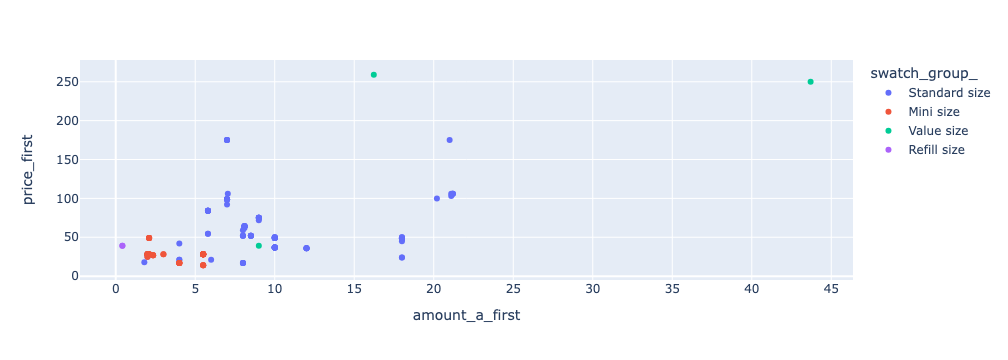

In [132]:
fig = px.scatter(solid_products[solid_products['lvl_2_cat_first']=='Candles'], x="amount_a_first", y="price_first", color="swatch_group_", hover_data=['brand_name_', 'product_name_'])
fig.show()